In [0]:
# Install required libraries
%pip install mlflow pandas scikit-learn matplotlib seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import os


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:

driver_standings = pd.read_csv('s3://columbia-gr5069-main/raw/driver_standings.csv')
races = pd.read_csv('s3://columbia-gr5069-main/raw/races.csv')

df = pd.merge(driver_standings, races, on="raceId")


In [0]:
df

,driverStandingsId,raceId,driverId,points,position,positionText,wins,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,18,1,10.0,1,1,1,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,18,2,8.0,2,2,0,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,18,3,6.0,3,3,0,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,18,4,5.0,4,4,0,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,18,5,4.0,5,5,0,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34119,72183,1110,846,69.0,8,8,0,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00,https://en.wikipedia.org/wiki/2023_Belgian_Gra...,2023-07-28,11:30:00,2023-07-29,10:30:00,\N,\N,2023-07-28,15:00:00,2023-07-29,14:30:00
34120,72184,1110,839,35.0,10,10,0,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00,https://en.wikipedia.org/wiki/2023_Belgian_Gra...,2023-07-28,11:30:00,2023-07-29,10:30:00,\N,\N,2023-07-28,15:00:00,2023-07-29,14:30:00
34121,72185,1110,844,99.0,5,5,0,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00,https://en.wikipedia.org/wiki/2023_Belgian_Gra...,2023-07-28,11:30:00,2023-07-29,10:30:00,\N,\N,2023-07-28,15:00:00,2023-07-29,14:30:00
34122,72186,1110,857,34.0,11,11,0,2023,12,13,Belgian Grand Prix,2023-07-30,13:00:00,https://en.wikipedia.org/wiki/2023_Belgian_Gra...,2023-07-28,11:30:00,2023-07-29,10:30:00,\N,\N,2023-07-28,15:00:00,2023-07-29,14:30:00


In [0]:
features = ["driverStandingsId", "driverId", "raceId", "position","points"]
target = "wins"

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
def train_and_log_model(model_type, params, X_train, X_test, y_train, y_test):
    # Set the experiment name
    mlflow.set_experiment("/Users/yw4381@columbia.edu/take-home-exercise-3-YihanWu123/take-home-exercise-3-YihanWu123")
    
    with mlflow.start_run() as run:
        # Log the model type
        mlflow.log_param("model_type", model_type)
        
        # Log all parameters
        for param_name, param_value in params.items():
            mlflow.log_param(param_name, param_value)
        
        # Create and train the model based on the model type
        if model_type == 'rf':
            model = RandomForestClassifier(**params, random_state=42)
        elif model_type == 'gb':
            model = GradientBoostingClassifier(**params, random_state=42)
        elif model_type == 'lr':
            model = LogisticRegression(**params, random_state=42)
        else:
            raise ValueError(f"Unknown model type: {model_type}")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Log the model
        signature = infer_signature(X_train, y_pred)
        mlflow.sklearn.log_model(model, "model", signature=signature)
        
        # Create and log confusion matrix plot
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        
        # Create and log feature importance plot (for tree-based models)
        if model_type in ['rf', 'gb']:
            plt.figure(figsize=(12, 6))
            feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
            feat_importances.nlargest(len(X_train.columns)).plot(kind='barh')
            plt.title('Feature Importances')
            plt.tight_layout()
            plt.savefig("feature_importance.png")
            mlflow.log_artifact("feature_importance.png")
        
        # Create and log classification report as CSV
        report = classification_report(y_test, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        report_df.to_csv("classification_report.csv")
        mlflow.log_artifact("classification_report.csv")
        
        # Print results
        print(f"Model: {model_type}")
        print(f"Parameters: {params}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("=" * 50)
        
        return model


Running Random Forest experiments...
Experiment 1/4


/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_disk0/.ephemeral_nfs/envs/pythonEnv-9ad9a846-e849-40b2-9553-e5f0dc67d1cc/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Val

Model: rf
Parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}
Accuracy: 0.9351
Precision: 0.9290
Recall: 0.9351
F1 Score: 0.9315
Experiment 2/4


/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_disk0/.ephemeral_nfs/envs/pythonEnv-9ad9a846-e849-40b2-9553-e5f0dc67d1cc/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Val

Model: rf
Parameters: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2}
Accuracy: 0.9574
Precision: 0.9556
Recall: 0.9574
F1 Score: 0.9559
Experiment 3/4


/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_disk0/.ephemeral_nfs/envs/pythonEnv-9ad9a846-e849-40b2-9553-e5f0dc67d1cc/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Val

Model: rf
Parameters: {'n_estimators': 150, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 4}
Accuracy: 0.9478
Precision: 0.9448
Recall: 0.9478
F1 Score: 0.9453
Experiment 4/4


/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_disk0/.ephemeral_nfs/envs/pythonEnv-9ad9a846-e849-40b2-9553-e5f0dc67d1cc/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Val

Model: rf
Parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}
Accuracy: 0.9653
Precision: 0.9643
Recall: 0.9653
F1 Score: 0.9644
Running Gradient Boosting experiments...
Experiment 1/3


/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_disk0/.ephemeral_nfs/envs/pythonEnv-9ad9a846-e849-40b2-9553-e5f0dc67d1cc/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Val

Model: gb
Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2}
Accuracy: 0.9118
Precision: 0.9070
Recall: 0.9118
F1 Score: 0.9080
Experiment 2/3


/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_disk0/.ephemeral_nfs/envs/pythonEnv-9ad9a846-e849-40b2-9553-e5f0dc67d1cc/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Val

Model: gb
Parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 5}
Accuracy: 0.9437
Precision: 0.9426
Recall: 0.9437
F1 Score: 0.9426
Experiment 3/3


/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_disk0/.ephemeral_nfs/envs/pythonEnv-9ad9a846-e849-40b2-9553-e5f0dc67d1cc/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Val

Model: gb
Parameters: {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 4, 'min_samples_split': 10}
Accuracy: 0.8287
Precision: 0.9010
Recall: 0.8287
F1 Score: 0.8610
Running Logistic Regression experiments...
Experiment 1/3


/databricks/python/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_disk0/.ephemeral_nfs/envs/pythonEnv-9ad9a846-e849-40b2-9553-e5f0dc67d1cc/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that inc

Model: lr
Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8844
Precision: 0.8159
Recall: 0.8844
F1 Score: 0.8467
Experiment 2/3


/databricks/python/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_disk0/.ephemeral_nfs/envs/pythonEnv-9ad9a846-e849-40b2-9553-e5f0dc67d1cc/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that inc

Model: lr
Parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8844
Precision: 0.8166
Recall: 0.8844
F1 Score: 0.8469
Experiment 3/3


/databricks/python/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/local_disk0/.ephemeral_nfs/envs/pythonEnv-9ad9a846-e849-40b2-9553-e5f0dc67d1cc/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that inc

Model: lr
Parameters: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.8929
Precision: 0.8527
Recall: 0.8929
F1 Score: 0.8704


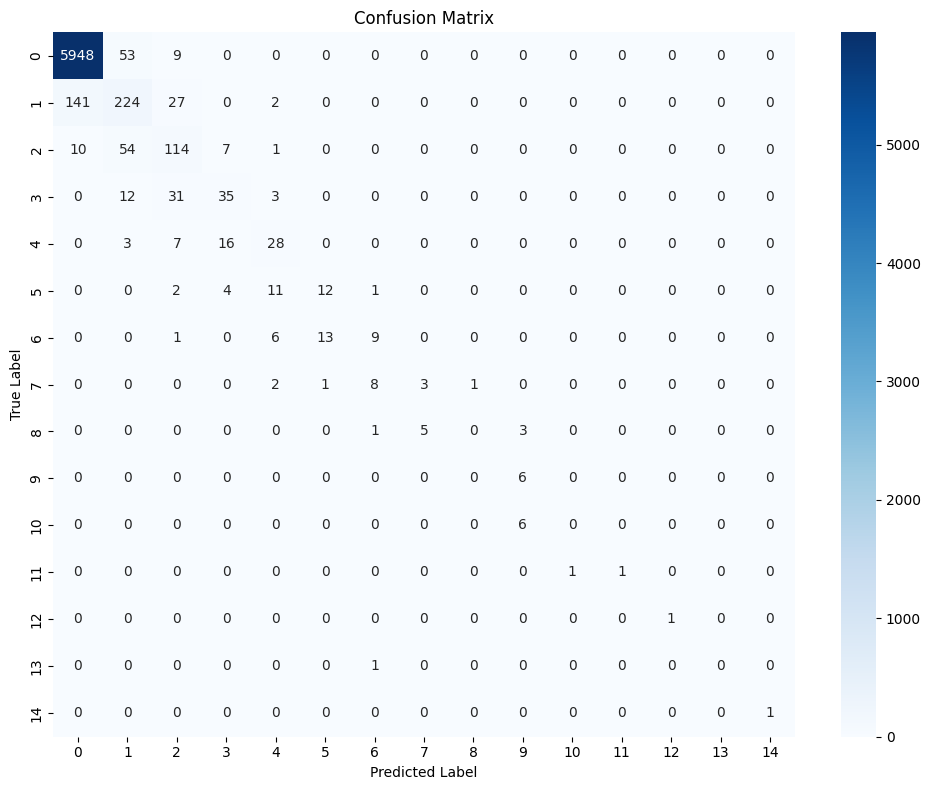

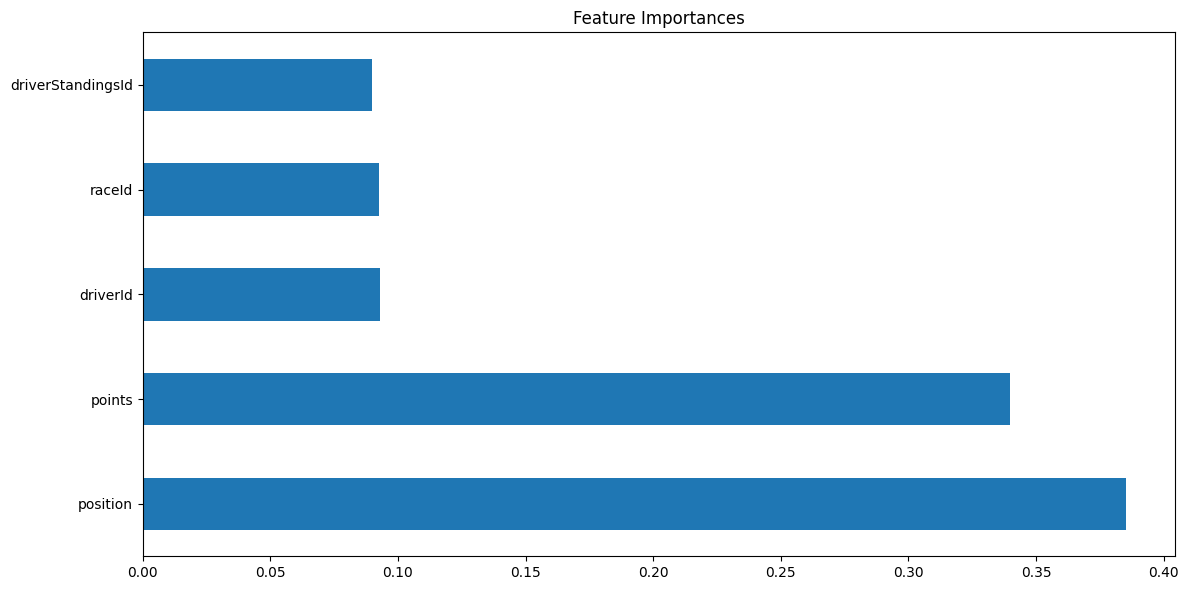

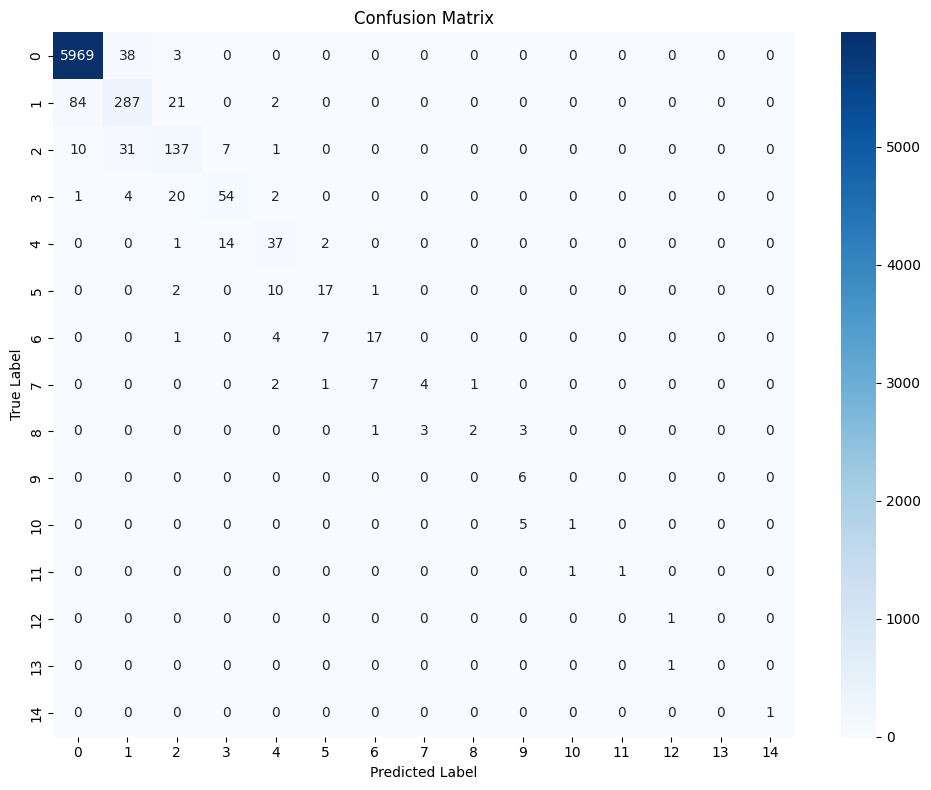

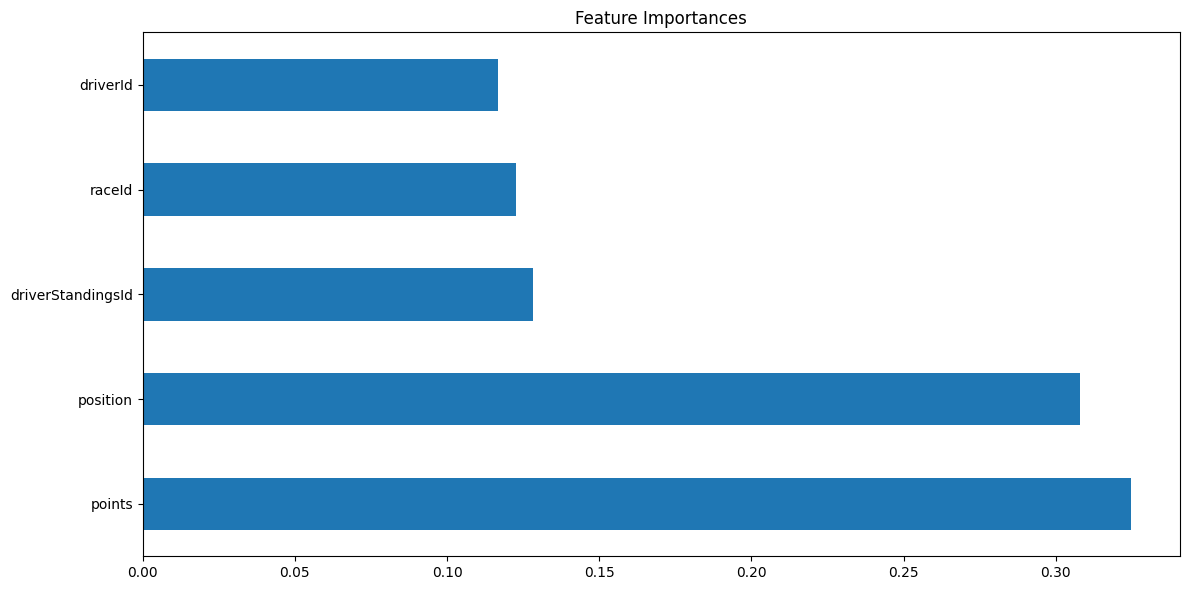

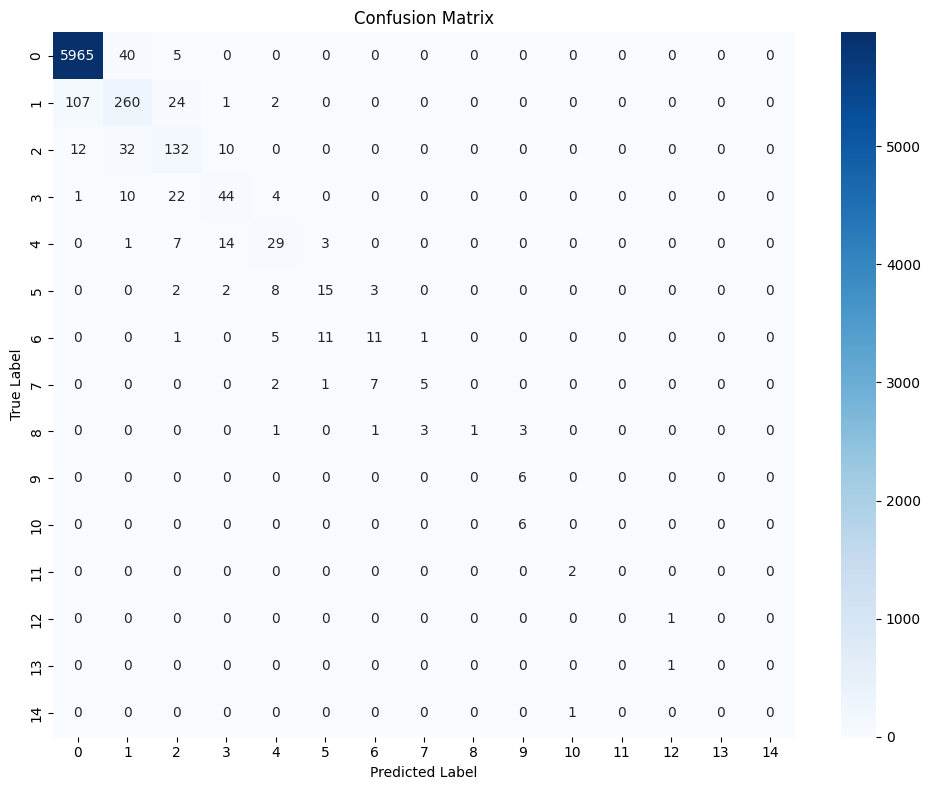

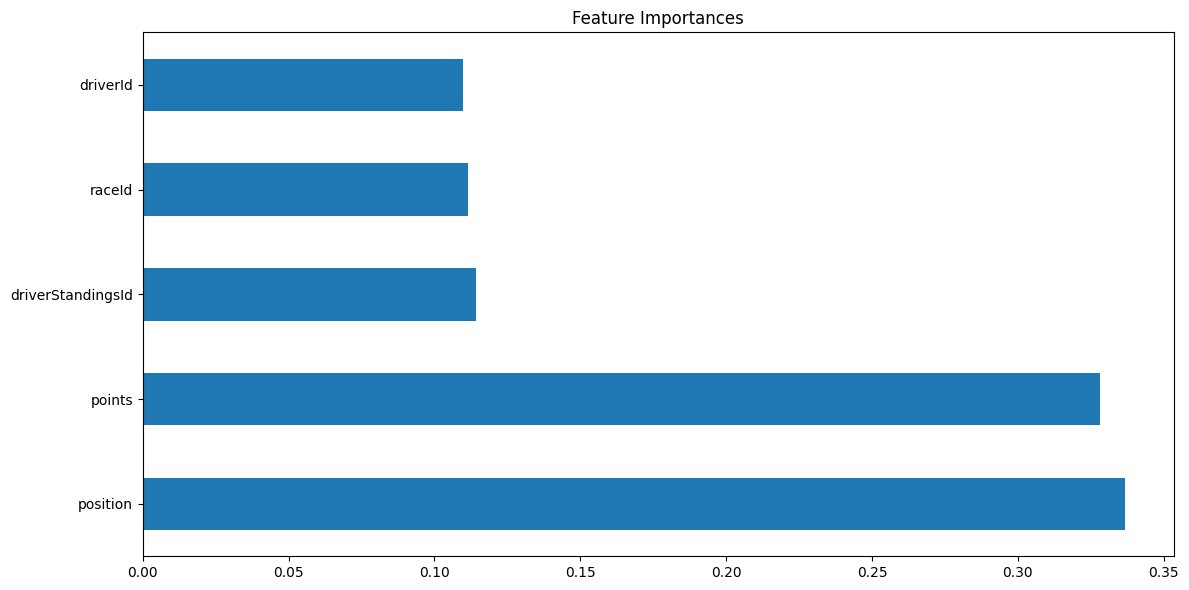

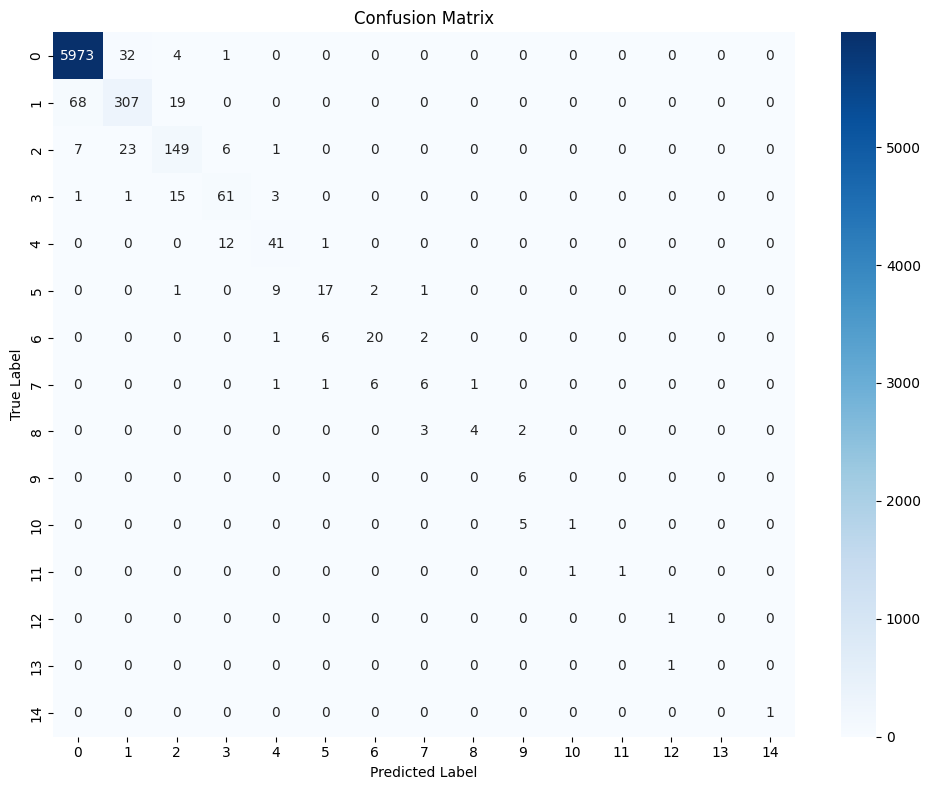

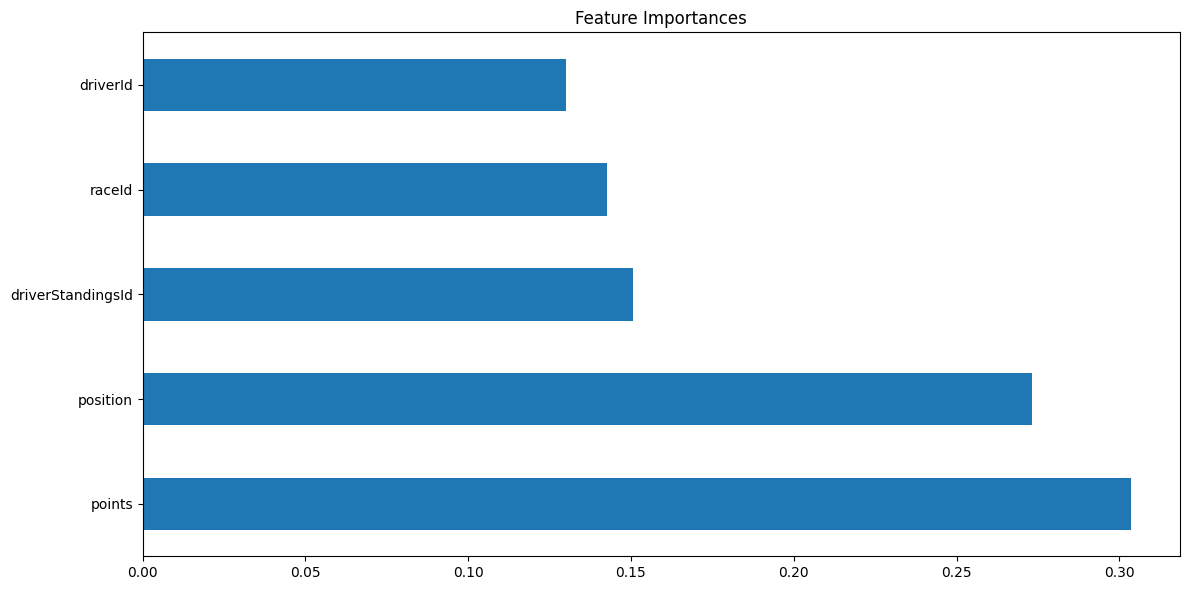

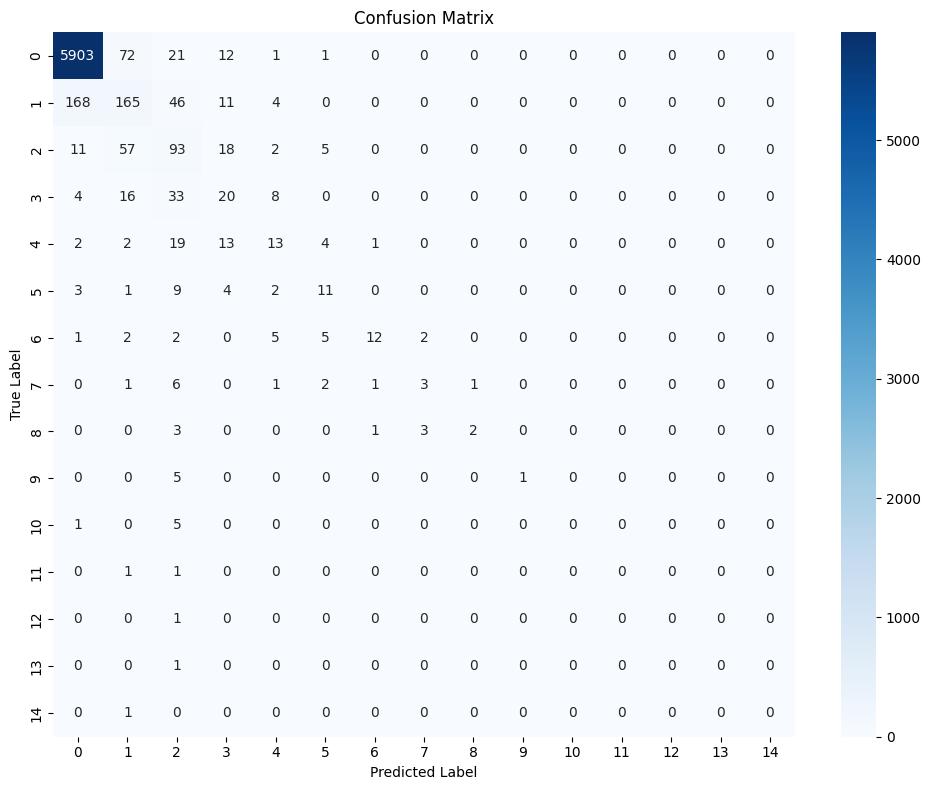

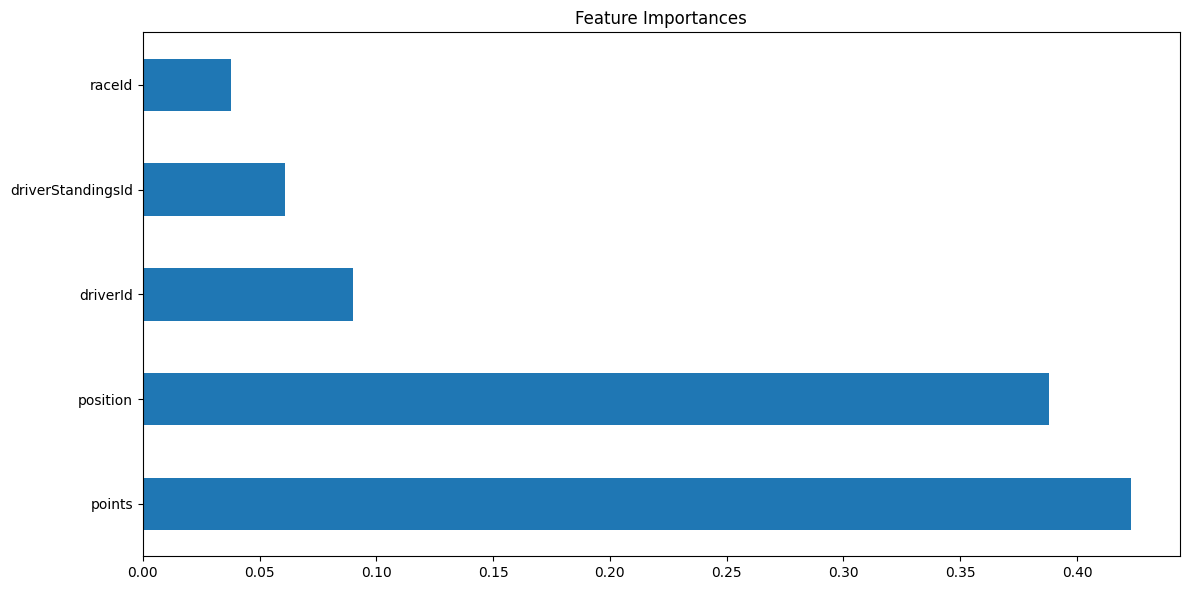

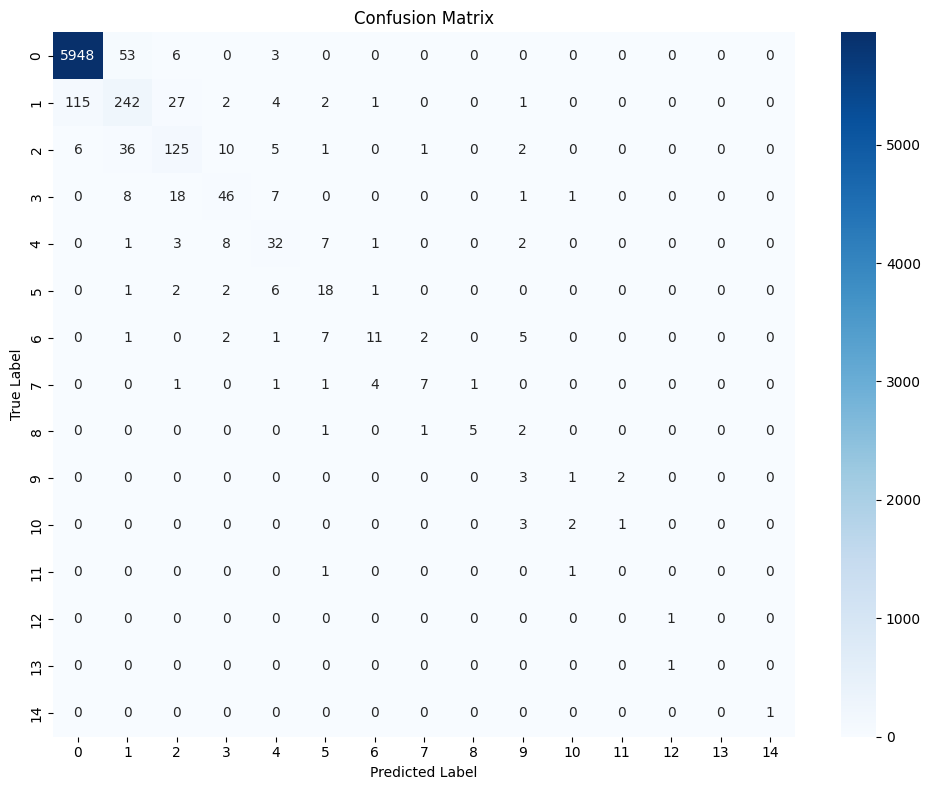

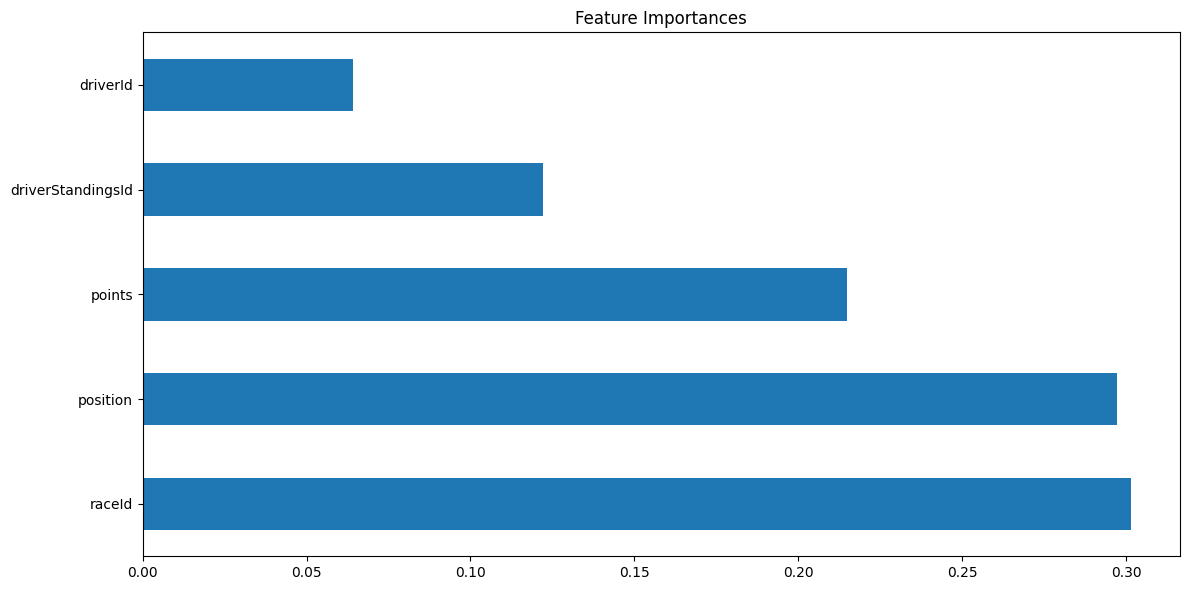

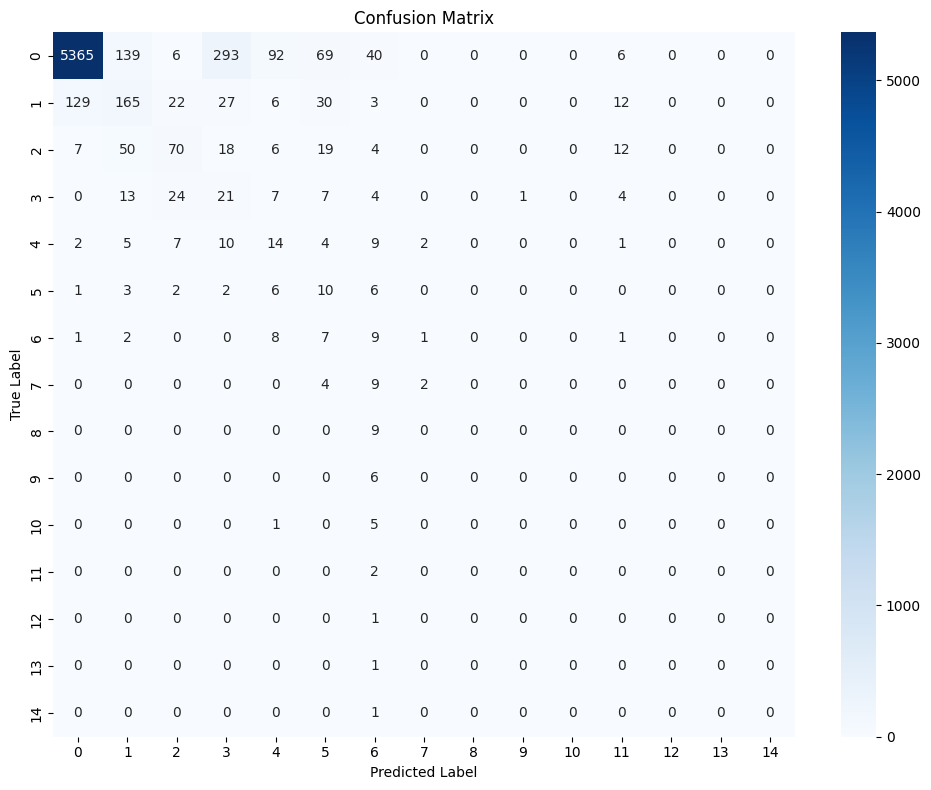

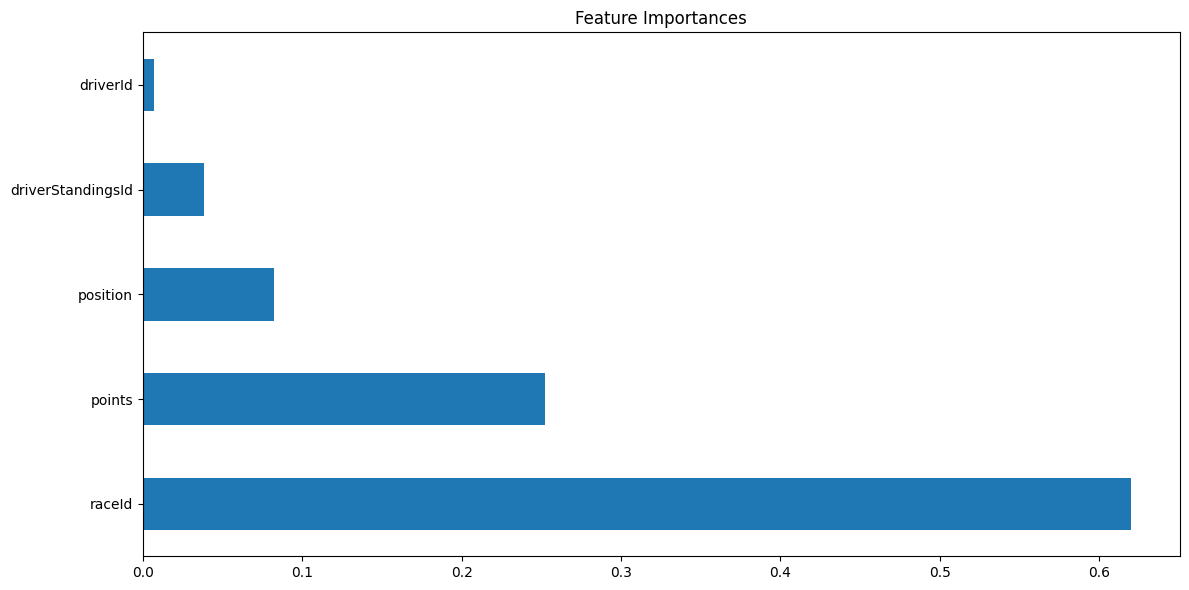

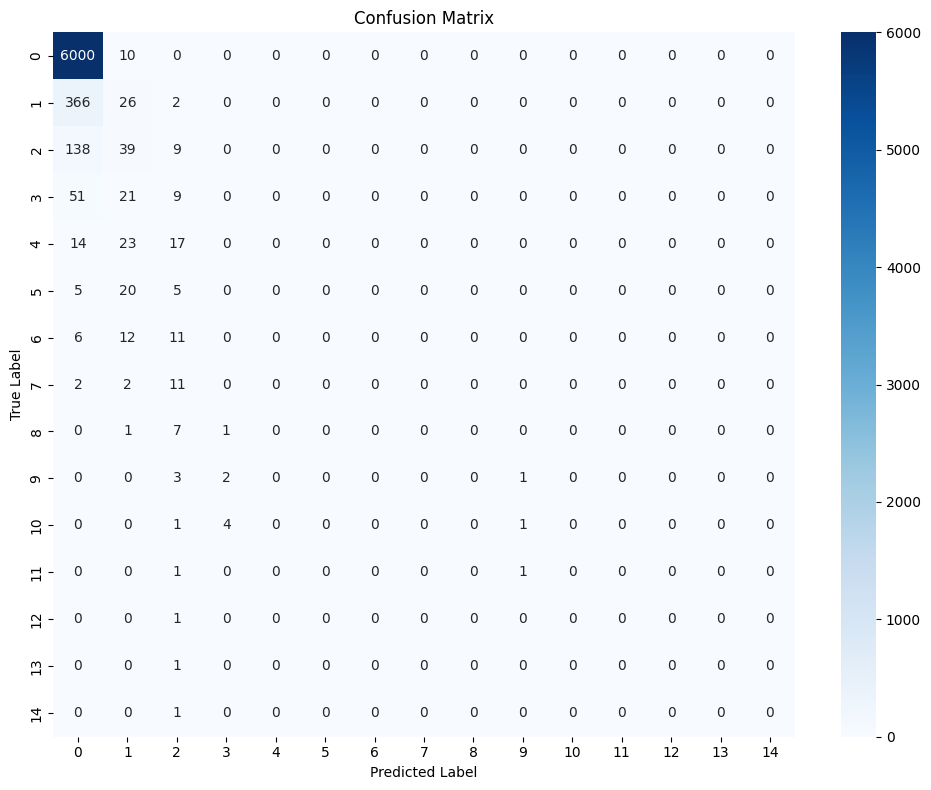

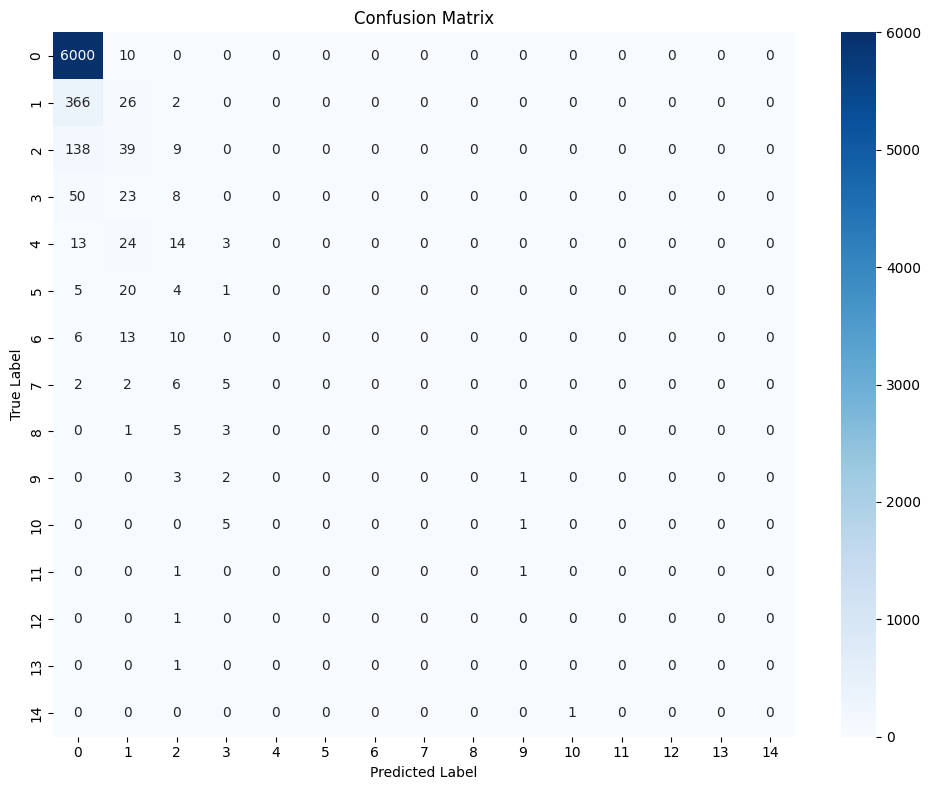

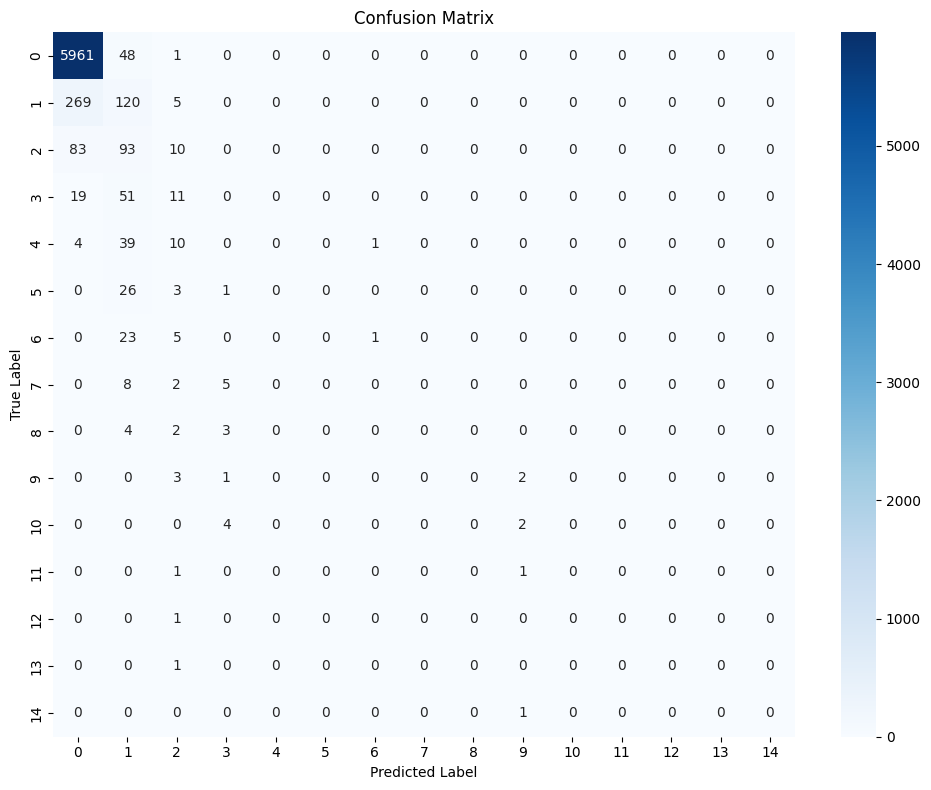

In [0]:
# Define different parameter configurations for our models
rf_params = [
    {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2},
    {'n_estimators': 150, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 4},
    {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}
]

gb_params = [
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2},
    {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 5},
    {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 4, 'min_samples_split': 10}
]

lr_params = [
    {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'},
    {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'},
    {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
]

# Run experiments for Random Forest
print("Running Random Forest experiments...")
for i, params in enumerate(rf_params):
    print(f"Experiment {i+1}/{len(rf_params)}")
    train_and_log_model('rf', params, X_train, X_test, y_train, y_test)

# Run experiments for Gradient Boosting
print("Running Gradient Boosting experiments...")
for i, params in enumerate(gb_params):
    print(f"Experiment {i+1}/{len(gb_params)}")
    train_and_log_model('gb', params, X_train, X_test, y_train, y_test)

# Run experiments for Logistic Regression
print("Running Logistic Regression experiments...")
for i, params in enumerate(lr_params):
    print(f"Experiment {i+1}/{len(lr_params)}")
    train_and_log_model('lr', params, X_train, X_test, y_train, y_test)


run_id,params.model_type,metrics.accuracy,metrics.precision,metrics.recall,metrics.f1_score
ce52c8a1469045d68749746f6c81079c,lr,0.8928937728937729,0.8526549407981445,0.8928937728937729,0.8703625901976166
bdc7b4ffa24246818b8ac00bfe57e407,lr,0.8843956043956044,0.8165911874186373,0.8843956043956044,0.846915327960287
fd07f2ae0d6a4f85997e0187cb676b3e,lr,0.8843956043956044,0.8158662701499074,0.8843956043956044,0.8467106453289459
f74ee369c7914123a515a8bea434e90d,gb,0.8287179487179487,0.9010060310966496,0.8287179487179487,0.8610265392759778
efe178b7bc3b49b6b908f2201f8a5c39,gb,0.9437362637362637,0.9425730635498072,0.9437362637362637,0.9425876553198342
289e21afe4f541cab0c19c4977fbd2ab,gb,0.9117948717948718,0.9070338761812903,0.9117948717948718,0.9080149545494174
f67deeddf241496b9767647d21088dca,rf,0.9652747252747252,0.9643229675585465,0.9652747252747252,0.9644083057202453
101b065e69524df59577b4d6cb3a9ade,rf,0.9478388278388279,0.9447599667374051,0.9478388278388279,0.9453397493747863
2c61e649c838425ca3d10a25ea1e15a3,rf,0.9573626373626374,0.9555976018615016,0.9573626373626374,0.9558603796181877
a79b3ac7cede44c6b2ee2b032b4c6f07,rf,0.9350915750915751,0.9290065332570229,0.9350915750915751,0.9314868487166253



=== Best Model ===
Run ID: f67deeddf241496b9767647d21088dca
Model Type: rf
Parameters:
  max_depth: 20
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 300

Metrics:
  accuracy: 0.9653
  f1_score: 0.9644
  precision: 0.9643
  recall: 0.9653

=== Detailed Analysis of Best Model ===


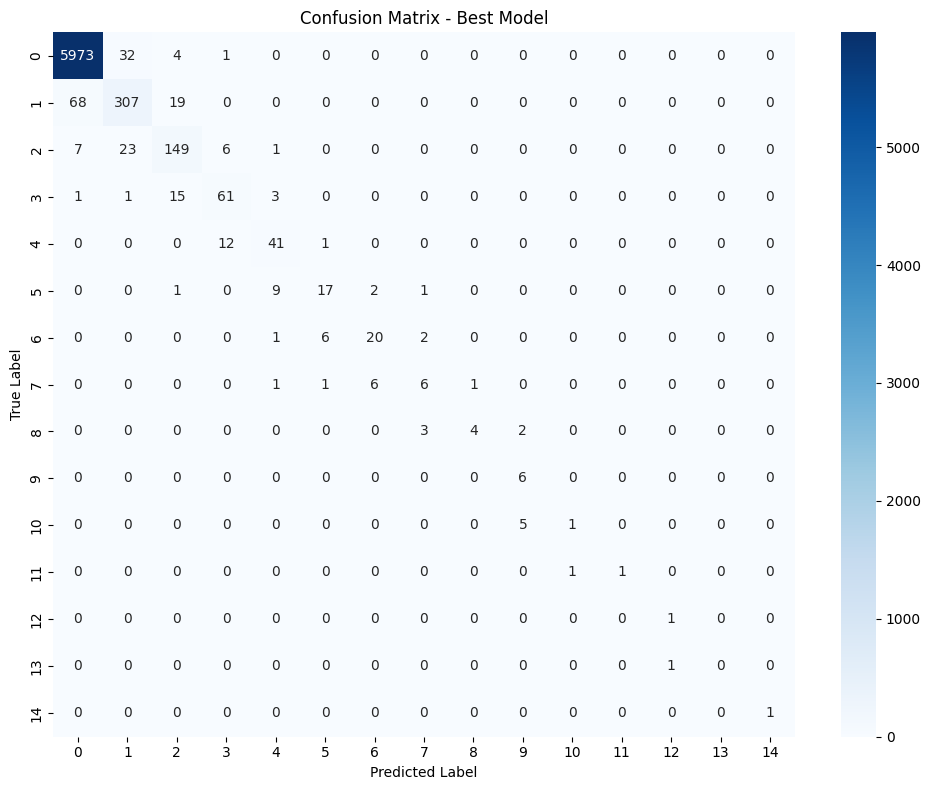


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6010
           1       0.85      0.78      0.81       394
           2       0.79      0.80      0.80       186
           3       0.76      0.75      0.76        81
           4       0.73      0.76      0.75        54
           5       0.68      0.57      0.62        30
           6       0.71      0.69      0.70        29
           7       0.50      0.40      0.44        15
           8       0.80      0.44      0.57         9
           9       0.46      1.00      0.63         6
          10       0.50      0.17      0.25         6
          11       1.00      0.50      0.67         2
          12       0.50      1.00      0.67         1
          13       0.00      0.00      0.00         1
          14       1.00      1.00      1.00         1

    accuracy                           0.97      6825
   macro avg       0.69      0.66      0.64      6825
we

/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


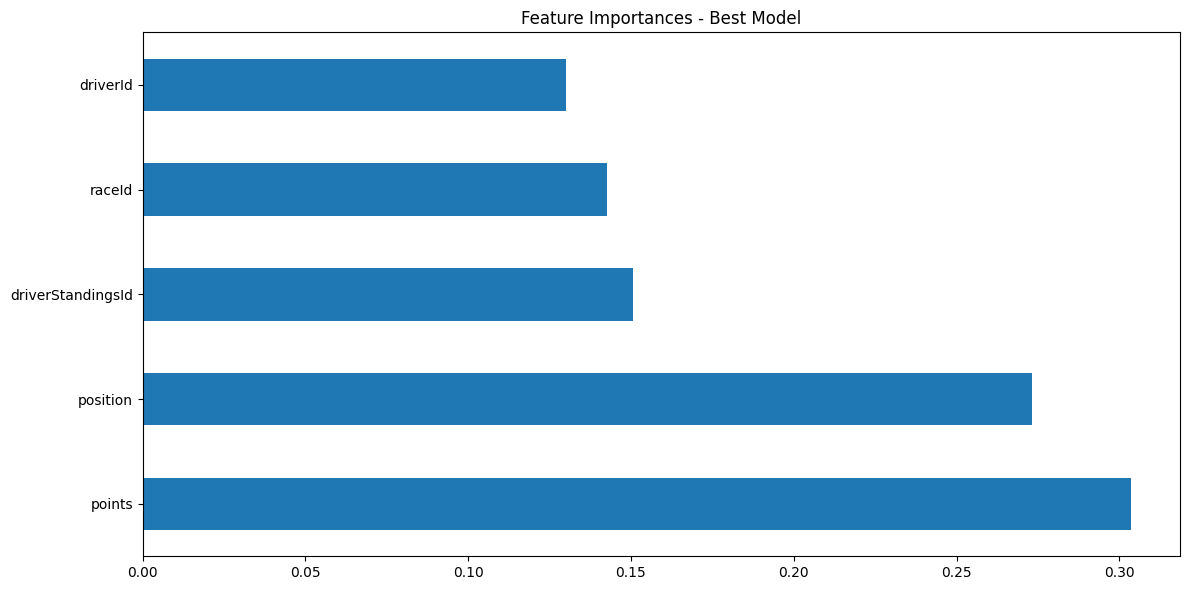

In [0]:
# Get all runs from the experiment
experiment_name = "/Users/yw4381@columbia.edu/take-home-exercise-3-YihanWu123/take-home-exercise-3-YihanWu123"
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id

# Get all runs for the experiment
runs = mlflow.search_runs(experiment_ids=[experiment_id])

# Display all runs with their metrics
display(runs[['run_id', 'params.model_type', 'metrics.accuracy', 'metrics.precision', 'metrics.recall', 'metrics.f1_score']])

# Find the best run based on F1 score
best_run_id = runs.loc[runs['metrics.f1_score'].idxmax()]['run_id']
best_run = mlflow.get_run(best_run_id)

print("\n=== Best Model ===")
print(f"Run ID: {best_run.info.run_id}")
print(f"Model Type: {best_run.data.params['model_type']}")
print("Parameters:")
for param_name, param_value in best_run.data.params.items():
    if param_name != 'model_type':
        print(f"  {param_name}: {param_value}")
print("\nMetrics:")
for metric_name, metric_value in best_run.data.metrics.items():
    print(f"  {metric_name}: {metric_value:.4f}")

# Load the best model
best_model = mlflow.sklearn.load_model(f"runs:/{best_run_id}/model")

# Create a detailed analysis of the best model
print("\n=== Detailed Analysis of Best Model ===")
y_pred = best_model.predict(X_test)

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Best Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance (if applicable)
if best_run.data.params['model_type'] in ['rf', 'gb']:
    plt.figure(figsize=(12, 6))
    feat_importances = pd.Series(best_model.feature_importances_, index=X_test.columns)
    feat_importances.nlargest(len(X_test.columns)).plot(kind='barh')
    plt.title('Feature Importances - Best Model')
    plt.tight_layout()
    plt.show()


In [0]:
print('The best model was selected based on the highest F1 score, which provides a balance between precision and recall. This metric is particularly important for our F1 race outcome prediction task because: F1 score combines precision and recall, ensuring the model performs well in identifying both positive and negative cases. With f1 score of 0.9644, rf model with Parameters: max_depth: 20 min_samples_leaf: 1 min_samples_split: 2  n_estimators: 300 won. Interestingly, the features that has the most impact on wins is position and points, for obvious reasons')

The best model was selected based on the highest F1 score, which provides a balance between precision and recall. This metric is particularly important for our F1 race outcome prediction task because: F1 score combines precision and recall, ensuring the model performs well in identifying both positive and negative cases. With f1 score of 0.9644, rf model with Parameters: max_depth: 20 min_samples_leaf: 1 min_samples_split: 2  n_estimators: 300 won. Interestingly, the features that has the most impact on wins is position and points, for obvious reasons
